# simu_file_handler の使い方サンプル
例として，二項分布をモンテカルロ法で近似するプログラムを用いる．  

二項分布は確率 p で成功する試行を n 回行ったとき，成功回数 X が従う確率分布のことである．  
今回は確率 p で成功する試行を n 回やる一連のプロセスを T 回繰り返し，合計 k 回成功した割合から二項分布を近似する．

したがって，シミュレーションに使うパラメータは以下である．
* n : 二項分布の試行の回数
* p : 試行の成功確率
* T : 二項分布自体を繰り返す回数

## 必要なライブラリをインポートする

In [81]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import simu_file_handler as sh   # simu_file_handler を読み込む

import importlib
importlib.reload(sh)

<module 'simu_file_handler' from '../simu_file_handler.py'>

## パラメータクラスを定義（SParameterを継承する）
シミュレーションの変数をここで定義する．

simu_file_handler モジュールにあるSParameterクラスを継承する必要があり，`__init__`メソッドもオーバーライドする．  
その際，必要な変数を`__init__`メソッドの引数に含め，内部で`self.pdict`という辞書に変数名とともに初期値を登録する．

（初期値は型だけ合わせておいて欲しい．int型でいいならint型の値，float型で使いたいならfloat型の値をなんでもいいから入れるなどする）

In [31]:
class Parameter(sh.SParameter):
    
    # パラメータの設定
    def __init__(self, n=10, p=0.5, T=10, sd=None):
        # 親クラスの初期化
        super().__init__(sd)
        
        self.pdict['n'] = n
        self.pdict['p'] = p
        self.pdict['T'] = T

## SimuFileHandler クラスのインスタンスを作る
SimuFileHandlerクラスには，
* データ格納用のフォルダのパス
* さっき作ったパラメータクラス

を渡す必要がある．

※ 先にデータ格納用のフォルダを作っておくこと！ 今回はこのJupyterファイルがあるフォルダの直下にdataフォルダを作成するとする．

In [82]:
folder = './data'
sfh = sh.SimuFileHandler(folder, Parameter())

## 二項分布をモンテカルロ法で近似する関数
ここは自分でモジュールを使う場合，好きに自分のシミュレーションコードを書くことになる．

今回は二項分布を例とするため，確率 p で成功する試行を n 回やり，成功した回数を記録することを T 回繰り返して成功割合の分布を得る．

In [10]:
def simulate_bd(param):
    pd = param.pdict

    result = np.zeros(pd['n']+1)

    for i in range(pd['T']):

        cnt = 0
        for j in range(pd['n']):
            cnt += 1 if np.random.rand() < pd['p'] else 0
        result[cnt] += 1

    result = result / pd['n']
    return result

## データを追加
上のシミュレーション用関数を用いてデータを作成し，データ格納用フォルダに追加しよう．

シミュレーションコードによりパラメータに紐づいたデータ（array-like）ができたら，`SimuFileHandler.add_one_result`メソッドを用いてファイルに追加できる．

ここでデータ格納用フォルダを見てみたならば，ファイルが1つ生成されており，中に1列のデータが収められていることが確認できるはず．

In [5]:
param = Parameter(n=10, p=0.5, T=10)
print(param)

result = simulate_bd(param)
print(result)

sfh.add_one_result(param, result)

n10_p50_T10
[0.  0.  0.1 0.1 0.3 0.2 0.2 0.  0.  0.1 0. ]


## シミュレーションを複数回やり，一度に追加
今度は複数のシミュレーション結果を一度に格納する．

結果は二次元配列（あるいはリスト）の形にして，それをパラメータクラスのインスタンスと一緒に`SimuFileHandler.add_results`メソッドにわたす．  
そうすると，またファイルの中身を見ると今度は10列に増えていることがわかる．

In [6]:
results = []
for i in range(9):
    r = simulate_bd(param)
    results.append(r)
print(results)

sfh.add_results(param, results)

[array([0. , 0. , 0. , 0.4, 0.2, 0.2, 0.1, 0. , 0.1, 0. , 0. ]), array([0. , 0. , 0. , 0.1, 0.3, 0.5, 0. , 0. , 0. , 0.1, 0. ]), array([0. , 0. , 0. , 0. , 0.3, 0.2, 0.3, 0.2, 0. , 0. , 0. ]), array([0. , 0. , 0. , 0.1, 0.2, 0.4, 0.2, 0. , 0. , 0.1, 0. ]), array([0. , 0. , 0. , 0.1, 0.1, 0.3, 0.3, 0.1, 0. , 0.1, 0. ]), array([0. , 0. , 0. , 0.2, 0. , 0.3, 0.2, 0.3, 0. , 0. , 0. ]), array([0. , 0. , 0.2, 0.1, 0.5, 0.1, 0. , 0.1, 0. , 0. , 0. ]), array([0. , 0. , 0.2, 0. , 0.2, 0.1, 0.2, 0.2, 0.1, 0. , 0. ]), array([0. , 0. , 0. , 0.2, 0.3, 0.1, 0.3, 0.1, 0. , 0. , 0. ])]


## 試行回数の確認
パラメータセットに対して，何回シミュレーションを行ったかを`SimuFileHandler.get_num_data`メソッドで調べることができる．

返り値は，(試行回数，データの種類数）がタプルで得られるため，(10, 11)と表示されて，試行回数が10，0〜10までの分布を調べたのでデータの種類数が11になっていることが確認できる．

In [7]:
sfh.get_num_data(param)

(10, 11)

## データを読み込んでプロット
収めていたデータを`SimuFileHandler.read_and_get_ave`メソッドで読み込んでみる．

その際，特に何も指定しなければ，すでに行われたシミュレーション回数で平均化された値が返る．  
したがって，今は10試行平均の値を受け取ることができる．

引数で`mx=5`などと指定すれば平均化する回数を指定することができる．

attempts: 10


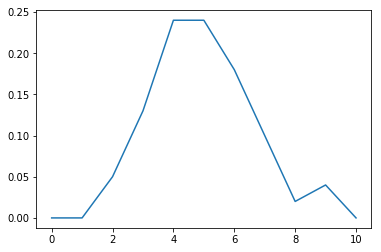

In [8]:
x = np.arange(0, param.pdict['n']+0.1, 1)
y = sfh.read_and_get_ave(param)

plt.plot(x,y)

## 他のパラメータでもやってみる

### n, p, T=10, 0.5, 1000
T を1000に増やすと1回しかシミュレーションをしなくても理想的な分布に近づく．

In [9]:
param2 = Parameter(n=10, p=0.5, T=1000)
print(param2)

result = simulate_bd(param2)
print(result)

sfh.add_one_result(param2, result)

n10_p50_T1000
[ 0.2  0.7  3.7 12.2 21.1 24.6 20.2 11.9  4.6  0.8  0. ]


attempts: 1


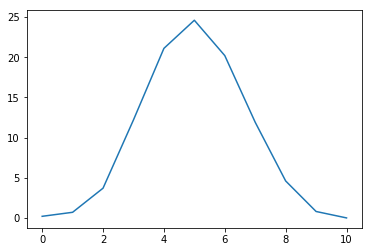

In [10]:
x = np.arange(0, param.pdict['n']+0.1, 1)
y = sfh.read_and_get_ave(param2)

plt.plot(x,y)

### n, p, T=10, 0.3, 1000
成功確率 p を0.3に変えてみる．

In [46]:
param3 = Parameter(n=10, p=0.3, T=1000)
print(param3)

result = simulate_bd(param3)
print(result)

sfh.add_one_result(param3, result)

n10_p30_T1000
[ 3.3 11.1 24.  27.6 19.8 10.1  3.1  0.8  0.2  0.   0. ]


attempts: 1


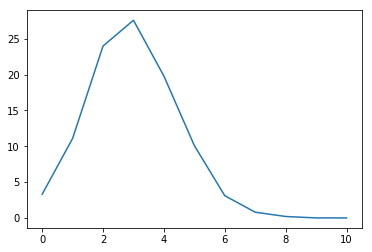

In [48]:
x = np.arange(0, param3.pdict['n']+0.1, 1)
y = sfh.read_and_get_ave(param3)

plt.plot(x,y)

## 最後に，データ格納用フォルダのサマリを表示
開発中だが，`SimuFileHandler.summary`メソッドを使うと，格納されたデータがどの変数について特に（いろいろ値を動かすことで）調査されているか，また2つ以上の変数を動かしている場合はあるかについて，視覚的に表示してシミュレーションの進捗を確認することができる．

Folder: data
Parameter: ['n', 'p', 'T']
# of values that was set to each variable. 


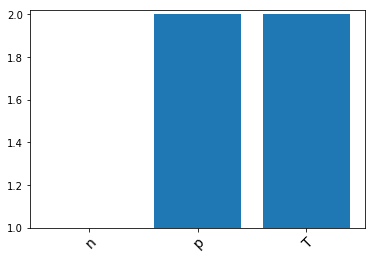

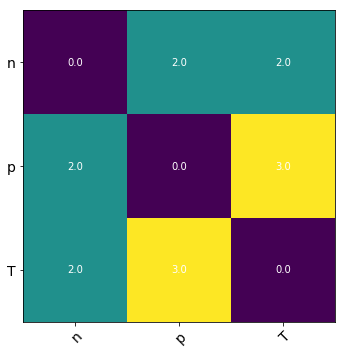

In [83]:
sfh.summary()